# Mean-variance optimisation

In this cookbook recipe, we work on several examples demonstrating PyPortfolioOpt's mean-variance capabilities. I will discuss what I think should be your "default" options, based on my experience in optimising portfolios.

To start, you need a list of tickers. Some people just provide the whole universe of stocks, but I don't think this is a good idea - portfolio optimisation is quite different from asset selection. I would suggest anywhere from 10-50 stocks as a starting point.

Some of the things we cover:

- Downloading data and getting it into PyPortfolioOpt
- Calculating and visualising the covariance matrix
- Optimising a long/short portfolio to minimise total variance
- Optimising a portfolio to maximise the Sharpe ratio, subject to sector constraints
- Optimising a portfolio to maximise return for a given risk, subject to sector constraints, with an L2 regularisation objective
- Optimising a market-neutral portfolio to minimise risk for a given level of return

Please consult the 

## Downloading data

To download data, we will use `yfinance`, an excellent library that provides free price data from Yahoo Finance, no API key needed.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA"] 

In [3]:
ohlc = yf.download(tickers, period="max")

[*********************100%***********************]  15 of 15 completed


In [4]:
prices = ohlc["Close"]
prices.tail()

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,
2020-04-22,172.309998,2363.489990,309.420013,100.989998,4.77,81.309998,89.339996,45.680000,29.709999,256.910004,173.520004,36.250000,732.109985,277.019989,42.130001
2020-04-23,172.899994,2399.449951,305.399994,101.000000,4.89,77.779999,89.389999,45.070000,30.139999,255.860001,171.419998,36.689999,705.630005,285.329987,43.450001
2020-04-24,175.460007,2410.219971,310.549988,101.190002,4.87,79.639999,90.709999,45.430000,29.330000,258.760010,174.550003,37.380001,725.150024,291.290009,43.730000
2020-04-27,179.429993,2376.000000,308.779999,106.059998,5.17,79.900002,94.620003,46.779999,29.110001,265.119995,174.050003,38.330002,798.750000,293.980011,43.939999
2020-04-28,178.360001,2314.080078,304.950012,106.209999,5.38,78.669998,95.290001,46.740002,29.690001,264.600006,169.809998,37.910000,769.119995,288.359985,44.970001


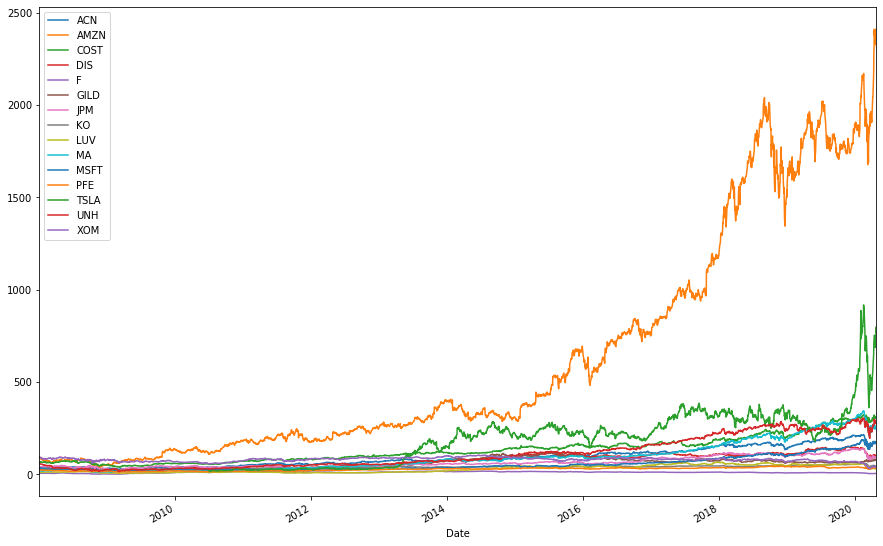

In [5]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

## Calculating the covariance matrix

In [6]:
import pypfopt
pypfopt.__version__

'1.2.1'

In [7]:
from pypfopt import risk_models
from pypfopt import Plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,XOM
ACN,0.093237,0.045569,0.027716,0.040676,0.043760,0.030402,0.049872,0.020071,0.035900,0.045170,0.040463,0.026729,0.037618,0.030807,0.030626
AMZN,0.045569,0.351349,0.048372,0.056606,0.054542,0.062826,0.070434,0.020886,0.049402,0.058004,0.072537,0.033782,0.051145,0.036059,0.028264
COST,0.027716,0.048372,0.104963,0.032944,0.031892,0.028353,0.040312,0.021527,0.032520,0.033693,0.037334,0.026277,0.021218,0.028010,0.021413
DIS,0.040676,0.056606,0.032944,0.099191,0.039687,0.033977,0.046787,0.026054,0.037101,0.049089,0.043246,0.030167,0.038831,0.032666,0.024694
F,0.043760,0.054542,0.031892,0.039687,0.124239,0.030982,0.053439,0.025976,0.043251,0.063604,0.041932,0.027720,0.051453,0.029447,0.025792
GILD,0.030402,0.062826,0.028353,0.033977,0.030982,0.248813,0.044629,0.017037,0.032451,0.035388,0.036888,0.033623,0.032935,0.035376,0.021805
JPM,0.049872,0.070434,0.040312,0.046787,0.053439,0.044629,0.130776,0.027708,0.047361,0.073454,0.051214,0.033549,0.041516,0.039271,0.031614
KO,0.020071,0.020886,0.021527,0.026054,0.025976,0.017037,0.027708,0.054362,0.022298,0.025416,0.028435,0.026551,0.018960,0.023163,0.020295
LUV,0.035900,0.049402,0.032520,0.037101,0.043251,0.032451,0.047361,0.022298,0.136321,0.045900,0.037628,0.026611,0.036029,0.033235,0.020670
MA,0.045170,0.058004,0.033693,0.049089,0.063604,0.035388,0.073454,0.025416,0.045900,0.121931,0.049687,0.034340,0.044928,0.044954,0.042093


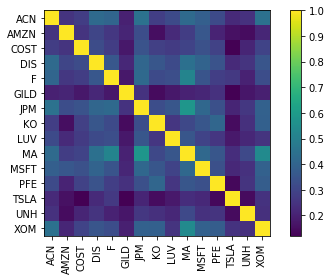

In [8]:
Plotting.plot_covariance(sample_cov);

For reasons discussed in the docs, the sample covariance matrix should not be your default choice. I think a better option is Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix. In the image below, we can see that there are fewer bright spots outside the diagonal:

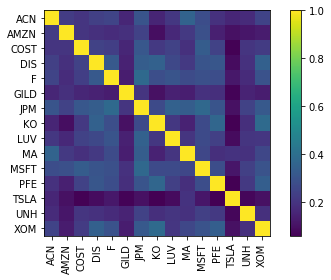

In [9]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
Plotting.plot_covariance(S);

## Return estimation

As discussed in the docs, it is often a bad idea to provide returns using a simple estimate like the mean of past returns. Generally, unless you have a proprietary method for estimating returns, I would skip this altogether and just find the `min_volatility()` portfolio or use `HRP`. 

However, if you insist, I suggest you use James-Stein shrinkage or CAPM returns, which aim to be slightly more stable than the default mean historical return. Please see the notebook `1-RiskReturnModels.ipynb` for more.

In [10]:
from pypfopt import expected_returns

In [11]:
mu = expected_returns.capm_return(prices)
mu

ACN     0.183741
AMZN    0.320742
COST    0.173676
DIS     0.195162
F       0.194314
GILD    0.230201
JPM     0.221041
KO      0.130592
LUV     0.195856
MA      0.231404
MSFT    0.210828
PFE     0.158542
TSLA    0.236669
UNH     0.195999
XOM     0.122601
Name: mkt, dtype: float64

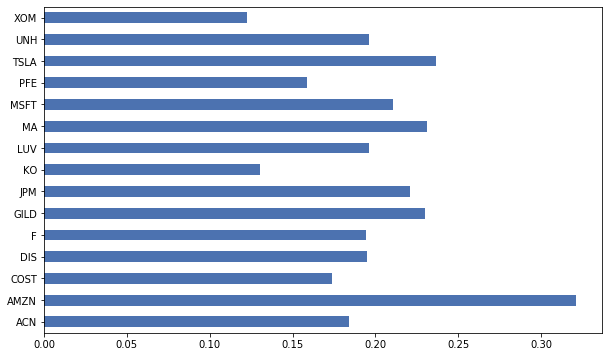

In [12]:
mu.plot.barh(figsize=(10,6));

## Long/short min variance

In this section, we construct a long/short portfolio with the objective of minimising variance. There is a good deal of research that demonstrates how global-minimum variance (GMV) portfolios outperform mean-variance optimised portfolios.

In [13]:
from pypfopt import EfficientFrontier

In [14]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.7/site-packages/pypfopt/efficient_frontier.py:98: UserWarning: No expected returns provided. You may only use ef.min_volatility()
  "No expected returns provided. You may only use ef.min_volatility()"


{'ACN': 0.22883,
 'AMZN': 0.00724,
 'COST': 0.09044,
 'DIS': -0.0157,
 'F': -0.0181,
 'GILD': 0.03821,
 'JPM': -0.0509,
 'KO': 0.11818,
 'LUV': 0.02707,
 'MA': 0.24155,
 'MSFT': 0.00463,
 'PFE': 0.05671,
 'TSLA': 0.17089,
 'UNH': 0.0271,
 'XOM': 0.07384}

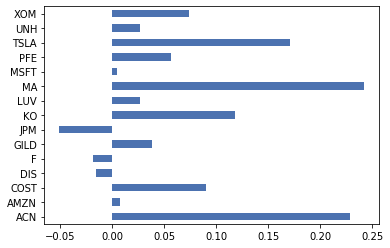

In [15]:
pd.Series(weights).plot.barh();

We can get a quick indication of the portfolio performance as follows. Note that this is an in sample estimate and may have very little resemblance to how the portfolio actually performs!

In [16]:
ef.portfolio_performance(verbose=True);

Annual volatility: 11.5%


Let's say we were happy with this portfolio and wanted to actually go out and buy the shares.  To do this, we would need to construct a **discrete allocation** (unless your broker supports fractional shares!)

If we had \$20,0000 to invest and would like our portfolio to be 130/30 long/short, we can construct the actual allocation as follows:

In [17]:
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $23.23 leftover


{'ACN': 24.0,
 'COST': 5.0,
 'GILD': 9.0,
 'KO': 47.0,
 'LUV': 17.0,
 'MA': 17.0,
 'MSFT': 1.0,
 'PFE': 28.0,
 'TSLA': 4.0,
 'UNH': 2.0,
 'XOM': 31.0,
 'DIS': -10.0,
 'F': -242.0,
 'JPM': -38.0}

## Max Sharpe with sector constraints

If you have your own model for returns (or have read the warnings and want to proceed anyways), you may consider maximising the Sharpe ratio. This theoretically gives the optimal portfolio in terms of risks-returns.

In this section, we construct a long-only max-sharpe portfolio, but also incorporate sector constraints. Sector constraints require three things. A `sector_mapper`, your `sector_lower` bounds, and your `sector_upper` bounds.

In [18]:
sector_mapper = {
    "MSFT": "Tech",
    "AMZN": "Consumer Discretionary",
    "KO": "Consumer Staples",
    "MA": "Financial Services",
    "COST": "Consumer Staples",
    "LUV": "Aerospace",
    "XOM": "Energy",
    "PFE": "Healthcare",
    "JPM": "Financial Services",
    "UNH": "Healthcare",
    "ACN": "Misc",
    "DIS": "Media",
    "GILD": "Healthcare",
    "F": "Auto",
    "TSLA": "Auto"
}

sector_lower = {
    "Consumer Staples": 0.1, # at least 10% to staples
    "Tech": 0.05 # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Tech": 0.2,
    "Aerospace":0.1,
    "Energy": 0.1,
    "Auto":0.15
}

We then set up the optimiser and add our constraints. We can use `ef.add_objective()` to add other constraints. For example, let's say that in addition to the above sector constraints, I specifically want:

- 10% of the portfolio in AMZN
- Less than 5% of my portfolio in TSLA

In [19]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

amzn_index = ef.tickers.index("AMZN")
ef.add_constraint(lambda w: w[amzn_index] == 0.10)

tsla_index = ef.tickers.index("TSLA")
ef.add_constraint(lambda w: w[tsla_index] <= 0.05)

ef.add_constraint(lambda w: w[10] >= 0.05)

ef.max_sharpe()
# ef.weights
weights = ef.clean_weights()
# weights

In [20]:
weights

{'ACN': 0.17159,
 'AMZN': 0.1,
 'COST': 0.05422,
 'DIS': 0.0,
 'F': 0.0,
 'GILD': 0.05808,
 'JPM': 0.0,
 'KO': 0.04578,
 'LUV': 0.01857,
 'MA': 0.40488,
 'MSFT': 0.05,
 'PFE': 0.01655,
 'TSLA': 0.05,
 'UNH': 0.03034,
 'XOM': 0.0}

We can immediately see that our explicit constraints were satisfied, and can check all the sector constraints as follows:


In [21]:
# O(N^2) loop not a good idea in a coding interview :)
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in weights.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Tech: 0.050
Auto: 0.050
Consumer Discretionary: 0.100
Consumer Staples: 0.100
Financial Services: 0.405
Misc: 0.172
Media: 0.000
Aerospace: 0.019
Healthcare: 0.105
Energy: 0.000


## Maximise return for a given risk, with L2 regularisation

Let's imagine that we've put a lot of thought into our risk tolerance, and have decided that we can't accept anything more than 15% volatility. We can use PyPortfolioOpt to construct a portfolio that maximises return for a given risk (with the same caveats about expected returns).

In [22]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=0.15)
weights = ef.clean_weights()
weights

{'ACN': 0.0,
 'AMZN': 0.2133,
 'COST': 0.1,
 'DIS': 0.0,
 'F': 0.0,
 'GILD': 0.05324,
 'JPM': 0.0,
 'KO': 0.0,
 'LUV': 0.0,
 'MA': 0.43346,
 'MSFT': 0.05,
 'PFE': 0.0,
 'TSLA': 0.15,
 'UNH': 0.0,
 'XOM': 0.0}

In [23]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

9/15 tickers have zero weight


In [24]:
ef.portfolio_performance(verbose=True);

Expected annual return: 24.4%
Annual volatility: 15.0%
Sharpe Ratio: 1.50


While this portfolio seems like it meets our objectives, we might be worried by the fact that a lot of the tickers have been assigned zero weight. In effect, the optimiser is "overfitting" to the data you have provided -- you are much more likely to get better results by enforcing some level of diversification. One way of doing this is to use **L2 regularisation** – essentially, adding a penalty on the number of near-zero weights.

In [25]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

{'ACN': 0.04731,
 'AMZN': 0.21883,
 'COST': 0.09128,
 'DIS': 0.01123,
 'F': 0.0,
 'GILD': 0.08818,
 'JPM': 0.0441,
 'KO': 0.00872,
 'LUV': 0.0227,
 'MA': 0.23222,
 'MSFT': 0.05,
 'PFE': 0.0,
 'TSLA': 0.15,
 'UNH': 0.03544,
 'XOM': 0.0}

In [26]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

3/15 tickers have zero weight


We can tune the value of gamma to choose the number of nonzero tickers. Larger gamma pulls portfolio weights towards an equal allocation.

In [27]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=1)  # gamme is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

{'ACN': 0.05737,
 'AMZN': 0.12587,
 'COST': 0.06077,
 'DIS': 0.06308,
 'F': 0.06266,
 'GILD': 0.0806,
 'JPM': 0.07602,
 'KO': 0.03923,
 'LUV': 0.06342,
 'MA': 0.0812,
 'MSFT': 0.07091,
 'PFE': 0.04477,
 'TSLA': 0.08383,
 'UNH': 0.0635,
 'XOM': 0.0268}

In [28]:
ef.portfolio_performance(verbose=True);

Expected annual return: 21.5%
Annual volatility: 14.7%
Sharpe Ratio: 1.33


The resulting portfolio still has a volatility of less than our 15% limit. It's in-sample Sharpe ratio has gone down, but this portfolio is a lot more robust for actual investment.

## Minimise risk for a given return, market-neutral

We may instead be in the situation where we have a certain required rate of return (maybe we are a pension fund that needs 7% return a year), but would like to minimise risk. Additionally, suppose we would like our portfolio to be market neutral, in the sense that it is equally exposed to the long and short sides.  

In [29]:
# Must have no weight bounds to allow shorts
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_objective(objective_functions.L2_reg)
ef.efficient_return(target_return=0.07, market_neutral=True)
weights = ef.clean_weights()
weights

{'ACN': -0.03872,
 'AMZN': 0.2571,
 'COST': -0.05991,
 'DIS': -0.00686,
 'F': -0.01044,
 'GILD': 0.06368,
 'JPM': 0.04842,
 'KO': -0.15416,
 'LUV': -0.00832,
 'MA': 0.07353,
 'MSFT': 0.02434,
 'PFE': -0.09054,
 'TSLA': 0.08397,
 'UNH': -0.00704,
 'XOM': -0.17504}

In [30]:
ef.portfolio_performance(verbose=True);

Expected annual return: 7.0%
Annual volatility: 12.0%
Sharpe Ratio: 0.42


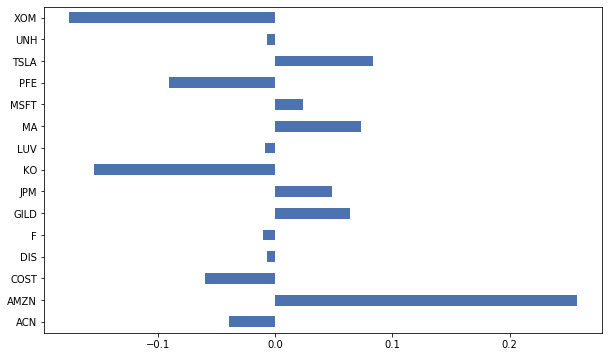

In [31]:
pd.Series(weights).plot.barh(figsize=(10,6));

In [32]:
print(f"Net weight: {sum(weights.values()):.2f}")

Net weight: 0.00
